In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages


plt.rcParams['font.size'] = 14.0
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'

In [2]:
# List to store all DataFrames
dfs = []

folder_path = '../results/round_metrics'

# Loop through all files in the folder
for file in os.listdir(folder_path):
    if file.endswith('.csv'):  # Ensure it's a CSV file
        file_path = os.path.join(folder_path, file)
        # Load the CSV file into a DataFrame and append it to the list
        dfs.append(pd.read_csv(file_path, index_col=0))

In [3]:
df =  pd.concat(dfs, ignore_index=True)

In [4]:
df['accuracy'] = 100 * df['accuracy'].round(4)
df['f1'] = 100 * df['f1'].round(4)

In [5]:
df['server_opt_lr_log10'] = np.log10(df['server_opt_lr']).round(1)
df['client_opt_lr_log10'] = np.log10(df['client_opt_lr']).round(1)

In [6]:
df_fed_opt = df[~df['fda']]

In [7]:
df_fda_opt = df[df['fda']]

In [8]:
best_performing = {
    ('MRPC', 'FedAdam'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -4},
    ('MRPC', 'FedAvg'): {'server_opt_lr_log10': 0, 'client_opt_lr_log10': -3},
    ('MRPC', 'FedAvgM'): {'server_opt_lr_log10': -1, 'client_opt_lr_log10': -3},
    ('MRPC', 'FedAdamW'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -5},
    ('MRPC', 'FedAdagrad'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -5}
}

In [9]:
def filter_unique_test(df, checkpoint, ds_path, ds_name, alpha, batch_size, num_clients, clients_per_round, fda):
    return df[
        (df['checkpoint'] == checkpoint) &
        (df['ds_path'] == ds_path) &
        (df['ds_name'] == ds_name) &
        (df['alpha'] == alpha) &
        (df['batch_size'] == batch_size) &
        (df['num_clients'] == num_clients) &
        (df['clients_per_round'] == clients_per_round) &
        (df['fda'] == fda)
    ]

In [10]:
def filter_opt(df, algo, **extra):
    if algo == 'FedAdam':
        return df[
            (df['server_opt_name'] == 'Adam') &
            (df['client_opt_name'] == 'SGD')
        ]
    if algo == 'FedAvg':
        return df[
            (df['server_opt_name'] == 'SGD') &
            (df['client_opt_name'] == 'SGD') &
            (df['server_opt_momentum'].isna())
        ]
    if algo =='FedYogi':
        return df[
            (df['server_opt_name'] == 'Yogi') &
            (df['client_opt_name'] == 'SGD')
        ]
    if algo == 'FedAvgM':
        return df[
            (df['server_opt_name'] == 'SGD') &
            (df['client_opt_name'] == 'SGD') &
            (df['server_opt_momentum'] == 0.9)
        ]
    if algo == 'FedAdagrad':
        return df[
            (df['server_opt_name'] == 'Adagrad') &
            (df['client_opt_name'] == 'SGD')
        ]
    if algo == 'FedAdamW':
        return df[
            (df['server_opt_name'] == 'AdamW') &
            (df['client_opt_name'] == 'SGD')
        ]

In [11]:
def learning_rate_grid(df, algo, round_num, ds_name, **extras):
    
    df_algo = filter_opt(df, algo, **extras)
    df_algo_round = df_algo[df_algo['round'] == round_num]
    
    # Pivot the DataFrame for easier plotting
    pivot_table = df_algo_round.pivot(index='client_opt_lr_log10', columns='server_opt_lr_log10', values='accuracy')

    # Extract unique learning rates and accuracy values
    client_opt_lr = pivot_table.index.astype(float)
    server_opt_lr = pivot_table.columns.astype(float)
    accuracy = pivot_table.values



    # Compute grid edges (midpoints)
    client_opt_lr_edges = []
    server_opt_lr_edges = []

    for axes_val in client_opt_lr:
        client_opt_lr_edges.append(axes_val - 0.5)
        client_opt_lr_edges.append(axes_val + 0.5)

    for axes_val in server_opt_lr:
        server_opt_lr_edges.append(axes_val - 0.5)
        server_opt_lr_edges.append(axes_val + 0.5)

    client_opt_lr_edges = sorted(list(set(client_opt_lr_edges)))
    server_opt_lr_edges = sorted(list(set(server_opt_lr_edges)))
    
    pdf = PdfPages(f'plots/{ds_name}_{algo}_{round_num}.pdf')

    # Create the plot
    plt.figure(figsize=(7.5, 7))
    #plt.figure(figsize=(6, 5))
    #plt.figure(figsize=(8, 6))

    # Add accuracy numbers inside the boxes
    for i in range(len(client_opt_lr)):
        for j in range(len(server_opt_lr)):
            plt.text(
                server_opt_lr[j],  # X-coordinate (server learning rate)
                client_opt_lr[i],  # Y-coordinate (client learning rate)
                f"{accuracy[i, j]:.1f}",  # Format the accuracy to 2 decimal places
                ha='center', va='center', color='black', fontsize=20  # Center the text and use a contrasting color
            )

    # Use pcolormesh with the adjusted edges
    mesh = plt.pcolormesh(
        server_opt_lr_edges,  # Server learning rate edges
        client_opt_lr_edges,  # Client learning rate edges
        accuracy,             # Accuracy values
        cmap='Blues',
        vmin=30,
        vmax=90
    )


    # Add color bar
    cbar = plt.colorbar(mesh)
    cbar.set_label('Accuracy')

    # Label the axes
    plt.xlabel('Server Learning Rate ($\log_{10}$)')
    plt.ylabel('Client Learning Rate ($\log_{10}$)')
    plt.title(f'{ds_name}, {algo}')
    
    plt.xticks(server_opt_lr)
    plt.yticks(client_opt_lr)

    # Show the plot
    #plt.show()
    
    pdf.savefig(plt.gcf()) # Save the current figure
    plt.close()
    pdf.close()

In [12]:
def learning_rate_grid_max(df, algo, ds_name, **extras):
    
    df_algo = filter_opt(df, algo, **extras)
    
    
    # Group by the specified columns and use a custom aggregation to find the first max based on smallest 'round'
    df_algo_round = (
        df_algo.sort_values(['accuracy', 'round'], ascending=[False, True])  # Sort by accuracy descending, then round ascending
        .groupby(['client_opt_lr_log10', 'server_opt_lr_log10'], as_index=False)
        .first()  # Select the first row in each group
    )
    #print(df_algo_round)
    
    
    # Pivot the DataFrame for easier plotting
    pivot_table = df_algo_round.pivot(index='client_opt_lr_log10', columns='server_opt_lr_log10', values='accuracy')

    # Extract unique learning rates and accuracy values
    client_opt_lr = pivot_table.index.astype(float)
    server_opt_lr = pivot_table.columns.astype(float)
    accuracy = pivot_table.values



    # Compute grid edges (midpoints)
    client_opt_lr_edges = []
    server_opt_lr_edges = []

    for axes_val in client_opt_lr:
        client_opt_lr_edges.append(axes_val - 0.5)
        client_opt_lr_edges.append(axes_val + 0.5)

    for axes_val in server_opt_lr:
        server_opt_lr_edges.append(axes_val - 0.5)
        server_opt_lr_edges.append(axes_val + 0.5)

    client_opt_lr_edges = sorted(list(set(client_opt_lr_edges)))
    server_opt_lr_edges = sorted(list(set(server_opt_lr_edges)))
    
    pdf = PdfPages(f'plots/max_{ds_name}_{algo}.pdf')

    # Create the plot
    plt.figure(figsize=(7.5, 7))
    #plt.figure(figsize=(6, 5))
    #plt.figure(figsize=(8, 6))

    # Add accuracy numbers inside the boxes
    for i in range(len(client_opt_lr)):
        for j in range(len(server_opt_lr)):
            plt.text(
                server_opt_lr[j],  # X-coordinate (server learning rate)
                client_opt_lr[i],  # Y-coordinate (client learning rate)
                f"{accuracy[i, j]:.1f}",  # Format the accuracy to 2 decimal places
                ha='center', va='center', color='black', fontsize=20  # Center the text and use a contrasting color
            )

    # Use pcolormesh with the adjusted edges
    mesh = plt.pcolormesh(
        server_opt_lr_edges,  # Server learning rate edges
        client_opt_lr_edges,  # Client learning rate edges
        accuracy,             # Accuracy values
        cmap='Blues',
        vmin=30,
        vmax=90
    )


    # Add color bar
    cbar = plt.colorbar(mesh)
    cbar.set_label('Accuracy')

    # Label the axes
    plt.xlabel('Server Learning Rate ($\log_{10}$)')
    plt.ylabel('Client Learning Rate ($\log_{10}$)')
    plt.title(f'{ds_name}, {algo}')
    
    plt.xticks(server_opt_lr)
    plt.yticks(client_opt_lr)

    # Show the plot
    #plt.show()
    
    pdf.savefig(plt.gcf()) # Save the current figure
    plt.close()
    pdf.close()

In [13]:
def fda_name(fed_opt):
    if fed_opt == 'FedAdam':
        return 'FDA-Adam'
    if fed_opt == 'FedAvg':
        return 'FDA-SGD'
    if fed_opt == 'FedAvgM':
        return 'FDA-SGDM'
    if fed_opt == 'FedAdagrad':
        return 'FDA-Adagrad'
    if fed_opt == 'FedAdamW':
        return 'FDA-AdamW'

# MRPC

clients = 10, per round = 10, max rounds = 100

In [14]:
best_accuracy = 90.2

In [15]:
df_fed_opt = df_fed_opt[df_fed_opt['round'] <= 100]
df_fda_opt = df_fda_opt[df_fda_opt['round'] <= 100]

## Best learning rate for FedOpt

In [16]:
df_mrpc = filter_unique_test(
    df_fed_opt, checkpoint='roberta-base', ds_path='glue', ds_name='mrpc', alpha=1., batch_size=8, num_clients=10, clients_per_round=10, fda=False
)

In [17]:
#learning_rate_grid(df_mrpc, 'FedAvgM', round_num=100, ds_name='MRPC', server_opt_momentum=0.9)
learning_rate_grid_max(df_mrpc, 'FedAvgM', ds_name='MRPC', server_opt_momentum=0.9)

In [18]:
#learning_rate_grid(df_mrpc, 'FedAdam', round_num=100, ds_name='MRPC')
learning_rate_grid_max(df_mrpc, 'FedAdam', ds_name='MRPC')

In [19]:
#learning_rate_grid(df_mrpc, 'FedAdamW', round_num=100, ds_name='MRPC')
learning_rate_grid_max(df_mrpc, 'FedAdamW', ds_name='MRPC')

In [20]:
#learning_rate_grid(df_mrpc, 'FedAdagrad', round_num=100, ds_name='MRPC')
learning_rate_grid_max(df_mrpc, 'FedAdagrad', ds_name='MRPC')

In [21]:
#learning_rate_grid(df_mrpc, 'FedAvg', round_num=100, ds_name='MRPC')
learning_rate_grid_max(df_mrpc, 'FedAvg', ds_name='MRPC')

In [22]:
df_adam = filter_opt(df_fed_opt, 'FedAdam')

In [23]:
df_adam['client_opt_lr_log10'].unique()

array([-3., -4., -5., -2., -1.])

In [24]:
df_adam['server_opt_lr_log10'].unique()

array([-5., -4., -1., -2., -3.])

## Variance

In [25]:
def plot_variance(df, log, algo):
    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.plot(df['round'], df['variance'], marker='o', linestyle='-', label='Variance')

    # Add grid
    plt.grid(True, linestyle='--', alpha=0.6)

    # Label the axes
    plt.xlabel('Round')
    plt.ylabel('Variance')
    
    if log: plt.yscale('log')

    # Add a title
    plt.title(algo)

    # Add a legend
    plt.legend()

    plt.show()

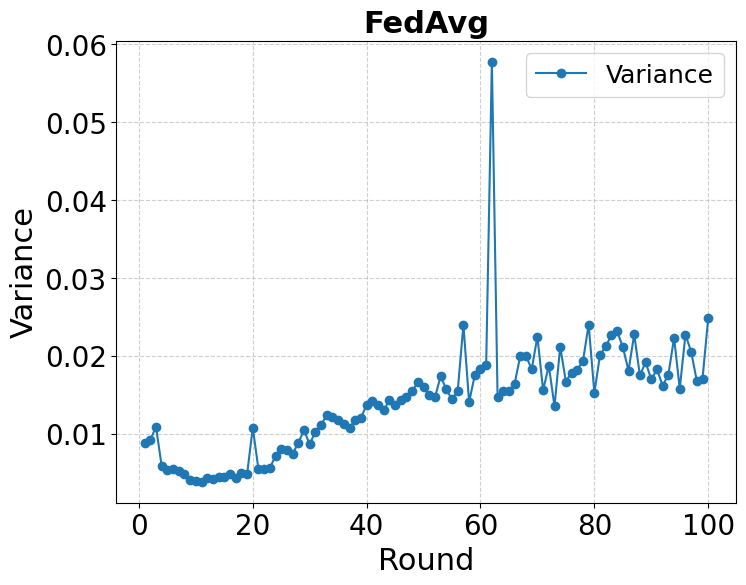

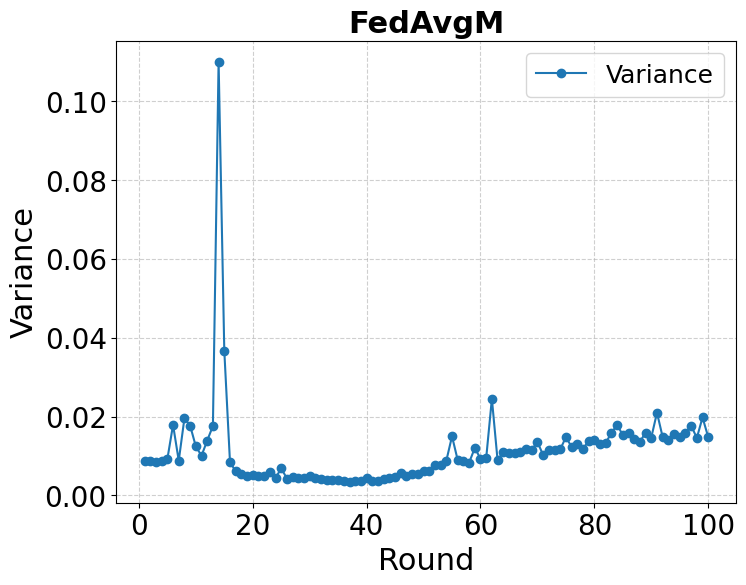

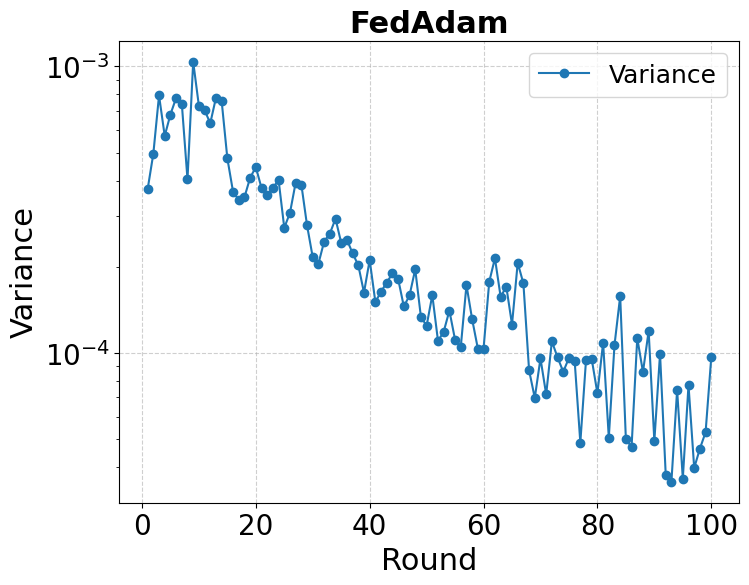

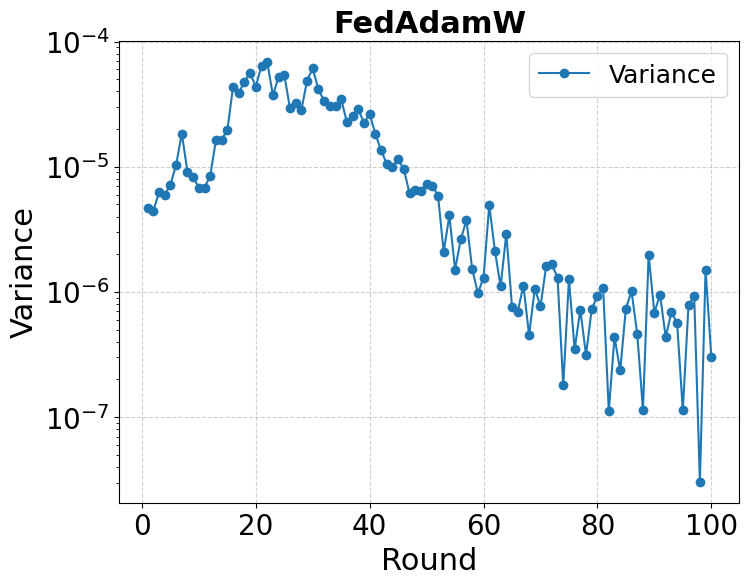

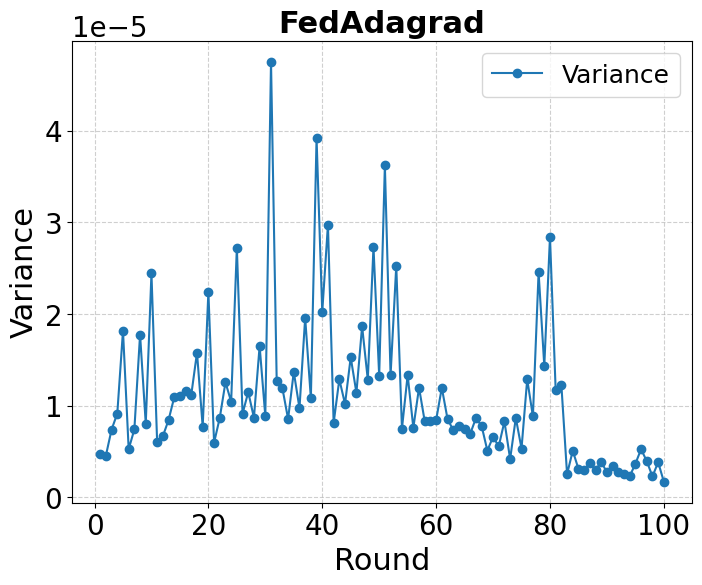

In [26]:
for alg in ['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdagrad']:
    
    df_fed_alg = filter_opt(df_fed_opt, alg)
    
    df_fed_alg = df_fed_alg[
        (df_fed_alg['server_opt_lr_log10'] == best_performing[('MRPC', alg)]['server_opt_lr_log10']) & 
        (df_fed_alg['client_opt_lr_log10'] == best_performing[('MRPC', alg)]['client_opt_lr_log10'])
    ]
    
    if alg in ['FedAdam', 'FedAdamW']:
        plot_variance(df_fed_alg, True, alg)
    else:
        plot_variance(df_fed_alg, False, alg)

## FDA vs Fed-Opt

In [27]:
percentages = [0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

In [28]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Algorithm", *percentages]

In [29]:
for alg in ['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdagrad']:

    df_fed_alg = filter_opt(df_fed_opt, alg)
    df_fda_alg = filter_opt(df_fda_opt, alg)

    df_fed_alg = df_fed_alg[
        (df_fed_alg['server_opt_lr_log10'] == best_performing[('MRPC', alg)]['server_opt_lr_log10']) & 
        (df_fed_alg['client_opt_lr_log10'] == best_performing[('MRPC', alg)]['client_opt_lr_log10'])
    ]

    df_fda_alg = df_fda_alg[
        (df_fda_alg['server_opt_lr_log10'] == best_performing[('MRPC', alg)]['server_opt_lr_log10']) & 
        (df_fda_alg['client_opt_lr_log10'] == best_performing[('MRPC', alg)]['client_opt_lr_log10'])
    ]
    
    fed_opt_row = [alg]
    fda_opt_row = [fda_name(alg)]
    
    for perc in percentages:
        acc = perc * best_accuracy
                
        def_fed_alg_best = df_fed_alg[df_fed_alg['accuracy'] >= acc]
        def_fda_alg_best = df_fda_alg[df_fda_alg['accuracy'] >= acc]
        
        if def_fed_alg_best.empty:
            fed_opt_row.append("-")
        else:
            fed_opt_row.append(def_fed_alg_best.iloc[0]['round'])
            
        if def_fda_alg_best.empty:
            fda_opt_row.append("-")
        else:
            fda_opt_row.append(def_fda_alg_best.iloc[0]['round'])
    
    table.add_row(fed_opt_row)
    table.add_row(fda_opt_row)

In [30]:
table

Algorithm,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
FedAvg,26,26,26,26,30,30,39,47,65,-
FDA-SGD,6,6,6,8,8,10,23,33,-,-
FedAvgM,52,53,54,63,66,66,71,77,83,-
FDA-SGDM,17,17,17,20,22,23,90,95,-,-
FedAdam,20,20,20,20,20,40,54,54,-,-
FDA-Adam,7,7,7,9,9,11,22,22,60,-
FedAdamW,17,17,18,22,22,25,27,27,35,35
FDA-AdamW,14,14,14,14,14,16,31,61,-,-
FedAdagrad,29,29,29,29,29,35,35,43,43,-
FDA-Adagrad,21,21,21,23,23,23,23,31,31,41
